BIDV

In [1]:
#. Import thư viện cần thiết
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [2]:
# Đọc file và tiền xử lí dữ liệu
df = pd.read_csv('../data/BID.csv')
# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)
    
# Áp dụng hàm chuyển đổi cho cột "Vol."
df["Vol."] = df["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
df["Change %"] = df["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
df['Price'] = df['Price'].apply(convert_str_to_number)
df['Open'] = df['Open'].apply(convert_str_to_number)
df['High'] = df['High'].apply(convert_str_to_number)
df['Low'] = df['Low'].apply(convert_str_to_number)


In [3]:
df1=df.reset_index()['Price']

In [4]:
#. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [5]:
#. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.3 * len(df1))

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]


In [6]:
#. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
#. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [8]:
# . Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)


In [9]:
# . Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
# . Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1248
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0092
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0059
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0053
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0037
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0028
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0025
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0019
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0017
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0014
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0014
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0012
Epoch 13/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0012
Epoch 14/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0011
Epoch 15/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - lo

In [11]:
# . Dự báo dữ liệu test
y_pred=model.predict(X_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [12]:
# . Chuẩn hóa dữ liệu y_pred

y_pred=scaler.inverse_transform(y_pred)

In [13]:
# Chuẩn hóa dữu liệuu y_test
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [14]:
# Tính RMSE
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Testing RMSE:', test_rmse)

# Tính MAPE (Mean Absolute Percentage Error)
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Testing MAPE:', test_mape)

#Tinh Mae
mae = np.mean(np.abs(np.array(y_pred) - np.array(y_test)))
print('Testing Mae:', mae)


Testing RMSE: 821.7720809559443
Testing MAPE: 2.010106834332552
Testing Mae: 601.0890881614963


In [15]:
# Dự báo 30 ngày tiếp theo
x_input=test_data[-100:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.09677985]
101
1 day input [0.09667164 0.11675661 0.12931218 0.10797067 0.10294779 0.09918144
 0.09918144 0.06779416 0.07030725 0.07156051 0.04519611 0.05021899
 0.04896245 0.05524188 0.05524188 0.03766342 0.03641016 0.04394285
 0.02762094 0.03515362 0.04770919 0.03766342 0.05021899 0.04770919
 0.05147553 0.03515362 0.03515362 0.03766342 0.03891997 0.02259805
 0.02259805 0.03264054 0.02762094 0.02762094 0.01757517 0.02008825
 0.03515362 0.         0.02259805 0.03013074 0.03515362 0.04268631
 0.05021899 0.04770919 0.07030725 0.06528436 0.06151802 0.05272879
 0.03891997 0.05021899 0.05775168 0.04519611 0.05272879 0.03515362
 0.01255557 0.04394285 0.06277456 0.06277456 0.09039222 0.0979249
 0.10545759 0.0979249  0.10043798 0.09039222 0.09039222 0.10671413
 0.10545759 0.10545759 0.12303604 0.10420433 0.11424681 0.11550335
 0.12931218 0.12303604 0.11173701 0.11801316 0.12805892 0.10545759
 0.12303604 0.13056872 0.12554584 0.10797067 0.0929053  0.0979249
 0.11299027 0.10545759 0.13810141 0

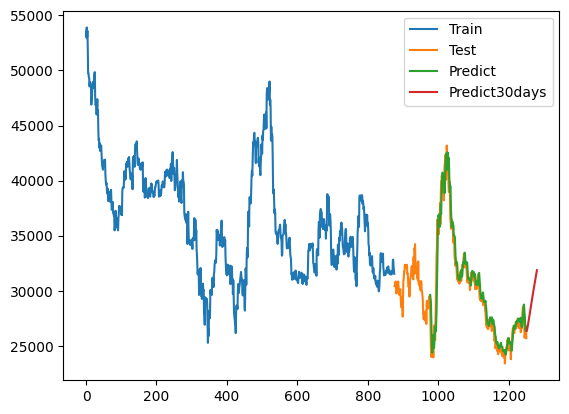

In [16]:
# 14.Vẽ hình du doan 30 ngay

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

In [17]:
# Dự báo 60 ngày tiếp theo
x_input=test_data[-100:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_60=[]
n_steps=100
i=0
while(i<60):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_60.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_60.extend(yhat.tolist())
        i=i+1

[0.09677985]
101
1 day input [0.09667164 0.11675661 0.12931218 0.10797067 0.10294779 0.09918144
 0.09918144 0.06779416 0.07030725 0.07156051 0.04519611 0.05021899
 0.04896245 0.05524188 0.05524188 0.03766342 0.03641016 0.04394285
 0.02762094 0.03515362 0.04770919 0.03766342 0.05021899 0.04770919
 0.05147553 0.03515362 0.03515362 0.03766342 0.03891997 0.02259805
 0.02259805 0.03264054 0.02762094 0.02762094 0.01757517 0.02008825
 0.03515362 0.         0.02259805 0.03013074 0.03515362 0.04268631
 0.05021899 0.04770919 0.07030725 0.06528436 0.06151802 0.05272879
 0.03891997 0.05021899 0.05775168 0.04519611 0.05272879 0.03515362
 0.01255557 0.04394285 0.06277456 0.06277456 0.09039222 0.0979249
 0.10545759 0.0979249  0.10043798 0.09039222 0.09039222 0.10671413
 0.10545759 0.10545759 0.12303604 0.10420433 0.11424681 0.11550335
 0.12931218 0.12303604 0.11173701 0.11801316 0.12805892 0.10545759
 0.12303604 0.13056872 0.12554584 0.10797067 0.0929053  0.0979249
 0.11299027 0.10545759 0.13810141 0

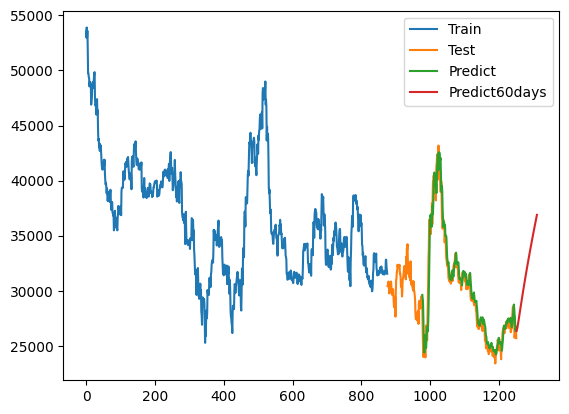

In [18]:
#Vẽ hình du doan 60 ngay

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
prediect_data_index_60 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index_60,scaler.inverse_transform(lst_output_60))

plt.legend(['Train','Test','Predict','Predict60days'])
plt.show()

In [19]:
# 13. Dự báo 90 ngày tiếp theo
x_input=test_data[-100:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_90=[]
n_steps=100
i=0
while(i<90):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_90.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_90.extend(yhat.tolist())
        i=i+1


[0.09677985]
101
1 day input [0.09667164 0.11675661 0.12931218 0.10797067 0.10294779 0.09918144
 0.09918144 0.06779416 0.07030725 0.07156051 0.04519611 0.05021899
 0.04896245 0.05524188 0.05524188 0.03766342 0.03641016 0.04394285
 0.02762094 0.03515362 0.04770919 0.03766342 0.05021899 0.04770919
 0.05147553 0.03515362 0.03515362 0.03766342 0.03891997 0.02259805
 0.02259805 0.03264054 0.02762094 0.02762094 0.01757517 0.02008825
 0.03515362 0.         0.02259805 0.03013074 0.03515362 0.04268631
 0.05021899 0.04770919 0.07030725 0.06528436 0.06151802 0.05272879
 0.03891997 0.05021899 0.05775168 0.04519611 0.05272879 0.03515362
 0.01255557 0.04394285 0.06277456 0.06277456 0.09039222 0.0979249
 0.10545759 0.0979249  0.10043798 0.09039222 0.09039222 0.10671413
 0.10545759 0.10545759 0.12303604 0.10420433 0.11424681 0.11550335
 0.12931218 0.12303604 0.11173701 0.11801316 0.12805892 0.10545759
 0.12303604 0.13056872 0.12554584 0.10797067 0.0929053  0.0979249
 0.11299027 0.10545759 0.13810141 0

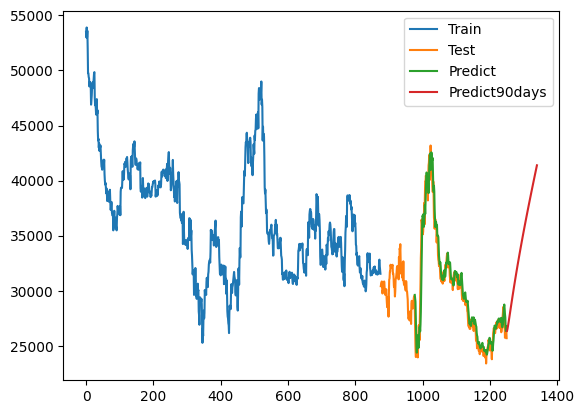

In [20]:
# 14.Vẽ hình 90 ngay 

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
prediect_data_index_90 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index_90,scaler.inverse_transform(lst_output_90))
plt.legend(['Train','Test','Predict','Predict90days'])
plt.show()

VIB


In [21]:
# Đọc file và tiền xử lí dữ liệu
df = pd.read_csv('../data/VIB.csv')
# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)
    
# Áp dụng hàm chuyển đổi cho cột "Vol."
df["Vol."] = df["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
df["Change %"] = df["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
df['Price'] = df['Price'].apply(convert_str_to_number)
df['Open'] = df['Open'].apply(convert_str_to_number)
df['High'] = df['High'].apply(convert_str_to_number)
df['Low'] = df['Low'].apply(convert_str_to_number)


In [22]:
df1=df.reset_index()['Price']

In [23]:
#. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [24]:
#. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.3 * len(df1))

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [25]:
#. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [26]:
#. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [27]:
# . Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)


In [28]:
# . Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [29]:
# . Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.2457
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0139
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0090
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0077
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0049
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0041
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0029
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0024
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0016
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0013
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0010
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0010
Epoch 13/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 8.7415e-04
Epoch 14/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.9001e-04
Epoch 15/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/s

In [30]:
# . Dự báo dữ liệu test

y_pred=model.predict(X_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [31]:
# . Chuẩn hóa dữ liệu y_pred
y_pred=scaler.inverse_transform(y_pred)

In [32]:
# Chuẩn hóa dữu liệuu y_test
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [33]:
# Tính RMSE
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Testing RMSE:', test_rmse)

# Tính MAPE (Mean Absolute Percentage Error)
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Testing MAPE:', test_mape)

#Tinh Mae
mae = np.mean(np.abs(np.array(y_pred) - np.array(y_test)))
print('Testing Mae:', mae)

Testing RMSE: 319.24205919192104
Testing MAPE: 1.7064825929321372
Testing Mae: 173.46482579848345


In [34]:
# Dự báo 30 ngày tiếp theo
x_input=test_data[-100:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.19189836]
101
1 day input [0.09677616 0.09370148 0.09370148 0.09677616 0.09677616 0.08907425
 0.09214892 0.08907425 0.07988067 0.06913452 0.06758197 0.06758197
 0.07065664 0.07065664 0.06554233 0.06106731 0.05363938 0.05363938
 0.05214771 0.05065603 0.05363938 0.05363938 0.05513105 0.05659229
 0.05659229 0.05363938 0.05363938 0.05659229 0.05659229 0.05214771
 0.05214771 0.05513105 0.05808396 0.06255898 0.06106731 0.067034
 0.06602941 0.06602941 0.0674602  0.0674602  0.0674602  0.06892143
 0.07035222 0.07178301 0.07324424 0.07467503 0.07467503 0.07324424
 0.07610582 0.07610582 0.07610582 0.07467503 0.17930531 0.17729611
 0.17324728 0.17525648 0.17930531 0.17930531 0.1813145  0.18536333
 0.19139091 0.19139091 0.18938172 0.18737252 0.19139091 0.19139091
 0.19139091 0.19543974 0.19543974 0.19543974 0.19744893 0.19744893
 0.19948857 0.20149776 0.19948857 0.19948857 0.19543974 0.19543974
 0.19543974 0.19139091 0.19139091 0.18536333 0.1813145  0.18332369
 0.19543974 0.18938172 0.19744893 0

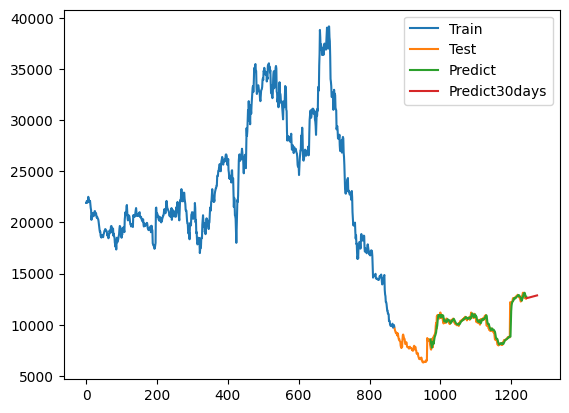

In [35]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

In [36]:
# Dự báo 60 ngày tiếp theo
x_input=test_data[-100:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_60=[]
n_steps=100
i=0
while(i<60):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_60.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_60.extend(yhat.tolist())
        i=i+1

[0.19189836]
101
1 day input [0.09677616 0.09370148 0.09370148 0.09677616 0.09677616 0.08907425
 0.09214892 0.08907425 0.07988067 0.06913452 0.06758197 0.06758197
 0.07065664 0.07065664 0.06554233 0.06106731 0.05363938 0.05363938
 0.05214771 0.05065603 0.05363938 0.05363938 0.05513105 0.05659229
 0.05659229 0.05363938 0.05363938 0.05659229 0.05659229 0.05214771
 0.05214771 0.05513105 0.05808396 0.06255898 0.06106731 0.067034
 0.06602941 0.06602941 0.0674602  0.0674602  0.0674602  0.06892143
 0.07035222 0.07178301 0.07324424 0.07467503 0.07467503 0.07324424
 0.07610582 0.07610582 0.07610582 0.07467503 0.17930531 0.17729611
 0.17324728 0.17525648 0.17930531 0.17930531 0.1813145  0.18536333
 0.19139091 0.19139091 0.18938172 0.18737252 0.19139091 0.19139091
 0.19139091 0.19543974 0.19543974 0.19543974 0.19744893 0.19744893
 0.19948857 0.20149776 0.19948857 0.19948857 0.19543974 0.19543974
 0.19543974 0.19139091 0.19139091 0.18536333 0.1813145  0.18332369
 0.19543974 0.18938172 0.19744893 0

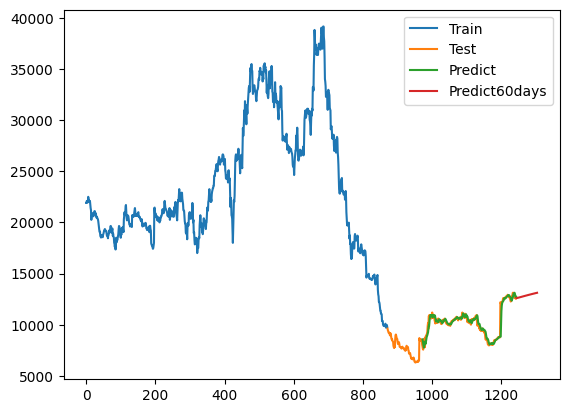

In [37]:
#Vẽ hình du doan 60 ngay

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
prediect_data_index_60 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index_60,scaler.inverse_transform(lst_output_60))

plt.legend(['Train','Test','Predict','Predict60days'])
plt.show()

In [38]:
# 13. Dự báo 90 ngày tiếp theo
x_input=test_data[-100:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_90=[]
n_steps=100
i=0
while(i<90):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_90.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_90.extend(yhat.tolist())
        i=i+1

[0.19189836]
101
1 day input [0.09677616 0.09370148 0.09370148 0.09677616 0.09677616 0.08907425
 0.09214892 0.08907425 0.07988067 0.06913452 0.06758197 0.06758197
 0.07065664 0.07065664 0.06554233 0.06106731 0.05363938 0.05363938
 0.05214771 0.05065603 0.05363938 0.05363938 0.05513105 0.05659229
 0.05659229 0.05363938 0.05363938 0.05659229 0.05659229 0.05214771
 0.05214771 0.05513105 0.05808396 0.06255898 0.06106731 0.067034
 0.06602941 0.06602941 0.0674602  0.0674602  0.0674602  0.06892143
 0.07035222 0.07178301 0.07324424 0.07467503 0.07467503 0.07324424
 0.07610582 0.07610582 0.07610582 0.07467503 0.17930531 0.17729611
 0.17324728 0.17525648 0.17930531 0.17930531 0.1813145  0.18536333
 0.19139091 0.19139091 0.18938172 0.18737252 0.19139091 0.19139091
 0.19139091 0.19543974 0.19543974 0.19543974 0.19744893 0.19744893
 0.19948857 0.20149776 0.19948857 0.19948857 0.19543974 0.19543974
 0.19543974 0.19139091 0.19139091 0.18536333 0.1813145  0.18332369
 0.19543974 0.18938172 0.19744893 0

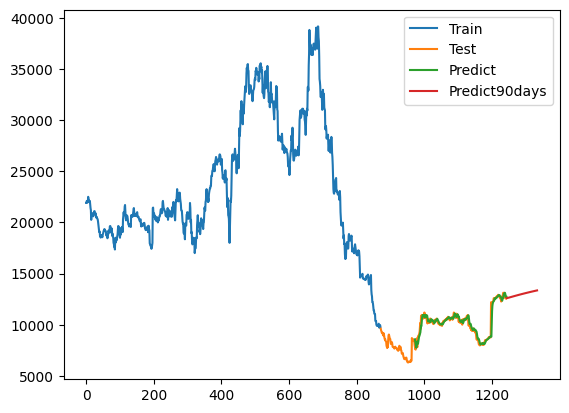

In [39]:
# 14.Vẽ hình 90 ngay 

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
prediect_data_index_90 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index_90,scaler.inverse_transform(lst_output_90))
plt.legend(['Train','Test','Predict','Predict90days'])
plt.show()

STB


In [40]:
# Đọc file và tiền xử lí dữ liệu
df = pd.read_csv('../data/STB.csv')
# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)
    
# Áp dụng hàm chuyển đổi cho cột "Vol."
df["Vol."] = df["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
df["Change %"] = df["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
df['Price'] = df['Price'].apply(convert_str_to_number)
df['Open'] = df['Open'].apply(convert_str_to_number)
df['High'] = df['High'].apply(convert_str_to_number)
df['Low'] = df['Low'].apply(convert_str_to_number)

In [41]:
df1=df.reset_index()['Price']

In [42]:
#. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [43]:
#. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.3 * len(df1))

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]


In [44]:
#. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [45]:
#. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [46]:
# . Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [47]:
# . Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [48]:
# . Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.2363
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0120
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0069
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0056
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0040
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0032
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0026
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0021
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0016
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0014
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0012
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0010
Epoch 13/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 8.1288e-04
Epoch 14/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 8.1883e-04
Epoch 15/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/s

In [49]:
# . Dự báo dữ liệu test
y_pred=model.predict(X_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [50]:
# . Chuẩn hóa dữ liệu y_pred

y_pred=scaler.inverse_transform(y_pred)

In [51]:
# Chuẩn hóa dữu liệuu y_test
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [52]:
# Tính RMSE
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Testing RMSE:', test_rmse)

# Tính MAPE (Mean Absolute Percentage Error)
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Testing MAPE:', test_mape)

#Tinh Mae
mae = np.mean(np.abs(np.array(y_pred) - np.array(y_test)))
print('Testing Mae:', mae)

Testing RMSE: 238.31338618636116
Testing MAPE: 1.485885557156601
Testing Mae: 156.9574482493157


In [53]:
# Dự báo 30 ngày tiếp theo
x_input=test_data[-100:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.19011226]
101
1 day input [0.14185639 0.14711033 0.14711033 0.15411559 0.14886165 0.14886165
 0.14360771 0.14185639 0.14360771 0.14711033 0.14535902 0.14185639
 0.14360771 0.14360771 0.14535902 0.14185639 0.14535902 0.14886165
 0.14185639 0.14010508 0.14711033 0.15236427 0.15411559 0.14535902
 0.14711033 0.14010508 0.13660245 0.14535902 0.15236427 0.15061296
 0.15236427 0.15411559 0.15761821 0.1558669  0.14886165 0.15236427
 0.15061296 0.15061296 0.1558669  0.15761821 0.1558669  0.15761821
 0.15761821 0.15761821 0.16462347 0.16637478 0.16637478 0.16287215
 0.16287215 0.16462347 0.16637478 0.16112084 0.16287215 0.16462347
 0.16112084 0.16987741 0.16812609 0.16637478 0.17688266 0.16112084
 0.16287215 0.15936953 0.16637478 0.16637478 0.14886165 0.1558669
 0.1558669  0.16112084 0.16637478 0.16812609 0.16637478 0.16812609
 0.17338004 0.17338004 0.17338004 0.17513135 0.17338004 0.17162872
 0.17863398 0.17162872 0.16987741 0.17688266 0.17513135 0.17338004
 0.18388792 0.1821366  0.19264448 

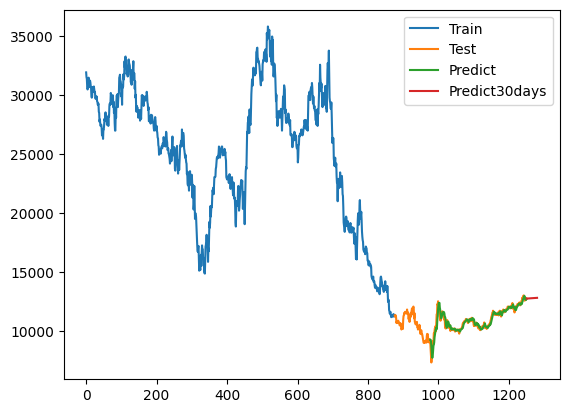

In [54]:
# 14.Vẽ hình du doan 30 ngay

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

In [55]:
# Dự báo 60 ngày tiếp theo
x_input=test_data[-100:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_60=[]
n_steps=100
i=0
while(i<60):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_60.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_60.extend(yhat.tolist())
        i=i+1

[0.19011226]
101
1 day input [0.14185639 0.14711033 0.14711033 0.15411559 0.14886165 0.14886165
 0.14360771 0.14185639 0.14360771 0.14711033 0.14535902 0.14185639
 0.14360771 0.14360771 0.14535902 0.14185639 0.14535902 0.14886165
 0.14185639 0.14010508 0.14711033 0.15236427 0.15411559 0.14535902
 0.14711033 0.14010508 0.13660245 0.14535902 0.15236427 0.15061296
 0.15236427 0.15411559 0.15761821 0.1558669  0.14886165 0.15236427
 0.15061296 0.15061296 0.1558669  0.15761821 0.1558669  0.15761821
 0.15761821 0.15761821 0.16462347 0.16637478 0.16637478 0.16287215
 0.16287215 0.16462347 0.16637478 0.16112084 0.16287215 0.16462347
 0.16112084 0.16987741 0.16812609 0.16637478 0.17688266 0.16112084
 0.16287215 0.15936953 0.16637478 0.16637478 0.14886165 0.1558669
 0.1558669  0.16112084 0.16637478 0.16812609 0.16637478 0.16812609
 0.17338004 0.17338004 0.17338004 0.17513135 0.17338004 0.17162872
 0.17863398 0.17162872 0.16987741 0.17688266 0.17513135 0.17338004
 0.18388792 0.1821366  0.19264448 

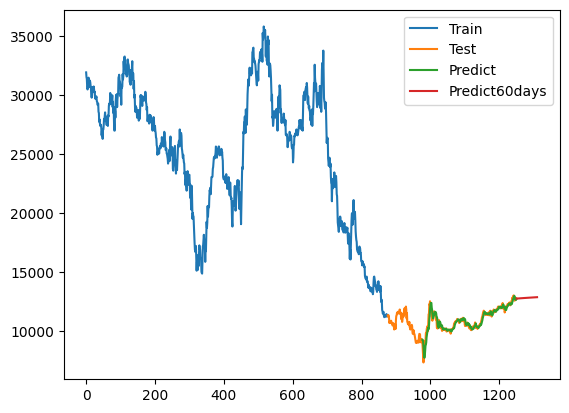

In [56]:
#Vẽ hình du doan 60 ngay

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
prediect_data_index_60 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index_60,scaler.inverse_transform(lst_output_60))

plt.legend(['Train','Test','Predict','Predict60days'])
plt.show()

In [57]:
# 13. Dự báo 90 ngày tiếp theo
x_input=test_data[-100:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_90=[]
n_steps=100
i=0
while(i<90):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_90.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_90.extend(yhat.tolist())
        i=i+1


[0.19011226]
101
1 day input [0.14185639 0.14711033 0.14711033 0.15411559 0.14886165 0.14886165
 0.14360771 0.14185639 0.14360771 0.14711033 0.14535902 0.14185639
 0.14360771 0.14360771 0.14535902 0.14185639 0.14535902 0.14886165
 0.14185639 0.14010508 0.14711033 0.15236427 0.15411559 0.14535902
 0.14711033 0.14010508 0.13660245 0.14535902 0.15236427 0.15061296
 0.15236427 0.15411559 0.15761821 0.1558669  0.14886165 0.15236427
 0.15061296 0.15061296 0.1558669  0.15761821 0.1558669  0.15761821
 0.15761821 0.15761821 0.16462347 0.16637478 0.16637478 0.16287215
 0.16287215 0.16462347 0.16637478 0.16112084 0.16287215 0.16462347
 0.16112084 0.16987741 0.16812609 0.16637478 0.17688266 0.16112084
 0.16287215 0.15936953 0.16637478 0.16637478 0.14886165 0.1558669
 0.1558669  0.16112084 0.16637478 0.16812609 0.16637478 0.16812609
 0.17338004 0.17338004 0.17338004 0.17513135 0.17338004 0.17162872
 0.17863398 0.17162872 0.16987741 0.17688266 0.17513135 0.17338004
 0.18388792 0.1821366  0.19264448 

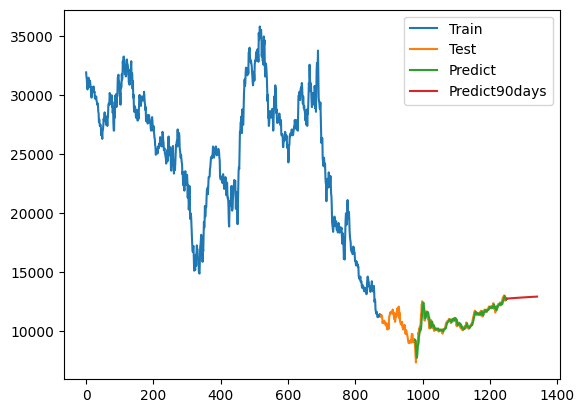

In [58]:
# 14.Vẽ hình 90 ngay 

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
prediect_data_index_90 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index_90,scaler.inverse_transform(lst_output_90))
plt.legend(['Train','Test','Predict','Predict90days'])
plt.show()